In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
from scipy import stats
from scipy.optimize import curve_fit
from data_generator import StressStrainDataGenerator

In [2]:
def get_stress_from_model(eps, C, n):
    """
    Implementation of the desired 
    non-linear stress-strain relation
    """
    return C*eps**(1.0/n)

In [6]:
# data is a collection of samples; each sample consists of stresses and strains data points stacked in rows
NUM_DATAPOINTS = 101
stressStrainDataGenerator = StressStrainDataGenerator(num_datapoints=NUM_DATAPOINTS) 
stressStrainDataGenerator.std_noise =  0.554
data, targets = stressStrainDataGenerator.generate_stress_strain_datasets(num_samples=2000,
                                                                          C_range=[5,15],
                                                                          n_range=[2,5],
                                                                          shuffle=True,
                                                                          add_noise=True,
                                                                          eps_linear_distributed=False)

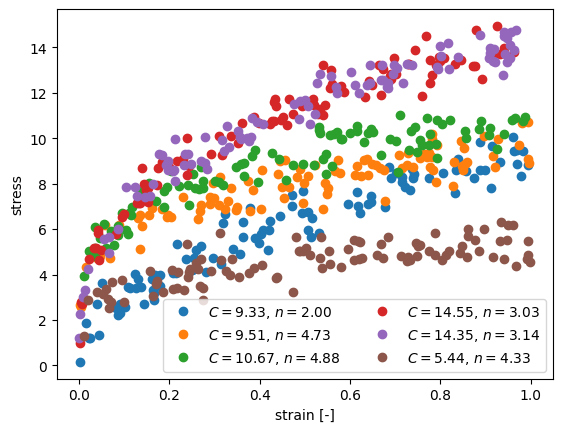

In [7]:
num_plotted_curves = 6
for sample_index in range(0, num_plotted_curves):
    x = data[sample_index][0]
    y = data[sample_index][1]
    label = '$C = {:.2f}$, $n = {:.2f}$'.format(*targets[sample_index])
    plt.plot(x, y, 'o', label=label)
plt.xlabel("strain [-]")
plt.ylabel("stress")
plt.legend(ncol=2);

In [8]:
# FIXME: reshape within data generator
num_samples, num_variables, datapoints = data.shape
data_reshape = data.reshape((num_samples, num_variables * datapoints))

In [9]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader, TensorDataset

data_reshape = torch.tensor(data_reshape, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)
dataset = TensorDataset(data_reshape, targets)
train_dataset, test_dataset = random_split(dataset, [0.7, 0.3])
print(len(train_dataset.indices))

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

1400


In [10]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(202, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=202, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 64.543091  [  100/ 1400]
loss: 6.656191  [ 1100/ 1400]
Test Error: Avg loss: 3.605973 

Epoch 2
-------------------------------
loss: 3.429391  [  100/ 1400]
loss: 1.091145  [ 1100/ 1400]
Test Error: Avg loss: 1.130991 

Epoch 3
-------------------------------
loss: 1.219294  [  100/ 1400]
loss: 1.172861  [ 1100/ 1400]
Test Error: Avg loss: 1.000102 

Epoch 4
-------------------------------
loss: 1.178358  [  100/ 1400]
loss: 0.980101  [ 1100/ 1400]
Test Error: Avg loss: 0.856370 

Epoch 5
-------------------------------
loss: 0.996356  [  100/ 1400]
loss: 0.944364  [ 1100/ 1400]
Test Error: Avg loss: 0.848257 

Epoch 6
-------------------------------
loss: 1.001488  [  100/ 1400]
loss: 0.907973  [ 1100/ 1400]
Test Error: Avg loss: 0.839065 

Epoch 7
-------------------------------
loss: 0.984313  [  100/ 1400]
loss: 0.903766  [ 1100/ 1400]
Test Error: Avg loss: 0.815111 

Epoch 8
-------------------------------
loss: 0.963928  [  100/ 1400

9.588760375976562 4.291004180908203
[9.508834  4.7291393]


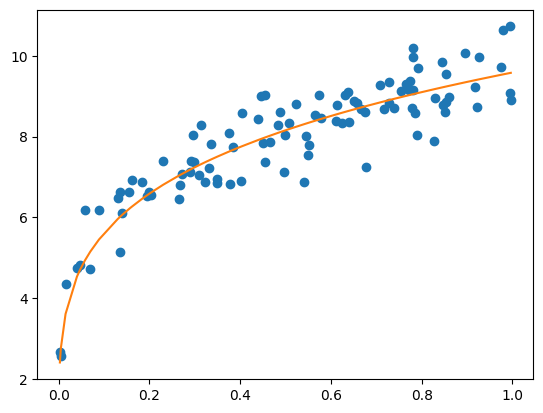

In [15]:
sample_number = 1
strains_stresses = data_reshape[sample_number]
C, n = model(strains_stresses)
print(C.item(), n.item())
print(targets[sample_number].numpy())
strains = torch.tensor(data[sample_number][0])
stresses = data[sample_number][1]
with torch.no_grad():
    pred_stresses = get_stress_from_model(strains, C, n)
plt.plot(strains, stresses, 'o')
plt.plot(strains, pred_stresses)
plt.show()